In [2]:
import numpy as np # linear algebra
import pandas as pd # 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
import random

In [3]:
#Enlace a google drive
from google.colab import drive
drive.mount('/content/drive')

#Direccion de contenido 
train_dir = ('/content/drive/MyDrive/chest_xray/train')
val_dir = ('/content/drive/MyDrive/chest_xray/val')
test_dir = ('/content/drive/MyDrive/chest_xray/test')

Mounted at /content/drive


In [4]:
# Definir tamaño de las imágenes y lotes de datos
img_width, img_height = 150, 150
batch_size = 12
# Preprocesamiento de datos con ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Found 1341 images belonging to 1 classes.
Found 3875 images belonging to 1 classes.


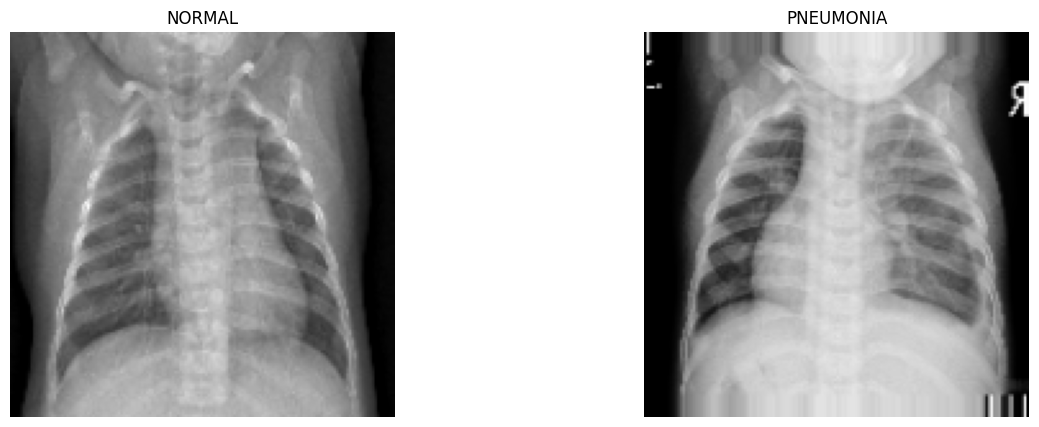

In [5]:
# Obtener una muestra de cada clase
class_names = train_generator.class_indices.keys()
samples = []
for class_name in class_names:
    sample_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(150, 150),
        batch_size=1,
        classes=[class_name])
    sample = sample_generator.next()[0][0]
    samples.append((class_name, sample))

# Visualizar las muestras
fig, axes = plt.subplots(nrows=1, ncols=len(samples), figsize=(15,5))
for ax, sample in zip(axes, samples):
    ax.imshow(sample[1])
    ax.set_title(sample[0])
    ax.axis('off')
plt.show()

In [ ]:
model = Sequential()

# Capa convolucional
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())

# Capa convolucional
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa convolucional
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa convolucional
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Capa completamente conectada (dense)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

# Capa de salida
model.add(Dense(2, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Creacion del modelo

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(train_generator, validation_data=validation_generator, epochs=14,callbacks=[early_stop, learning_rate_reduction])


Epoch 1/14
435/435 [==============================] - 114s 250ms/step - loss: 0.3914 - accuracy: 0.8581 - val_loss: 3.0209 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/14
435/435 [==============================] - 107s 247ms/step - loss: 0.2703 - accuracy: 0.8907 - val_loss: 2.0554 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/14
435/435 [==============================] - 107s 247ms/step - loss: 0.2458 - accuracy: 0.9086 - val_loss: 2.3704 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/14
435/435 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.9168
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
435/435 [==============================] - 109s 251ms/step - loss: 0.2294 - accuracy: 0.9168 - val_loss: 4.4445 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/14
435/435 [==============================] - 108s 248ms/step - loss: 0.1872 - accuracy: 0.9270 - val_loss: 1.0780 - val_accuracy: 0.6875 - lr: 2.0000e-04
Epoch 6/14
435/435 [===================

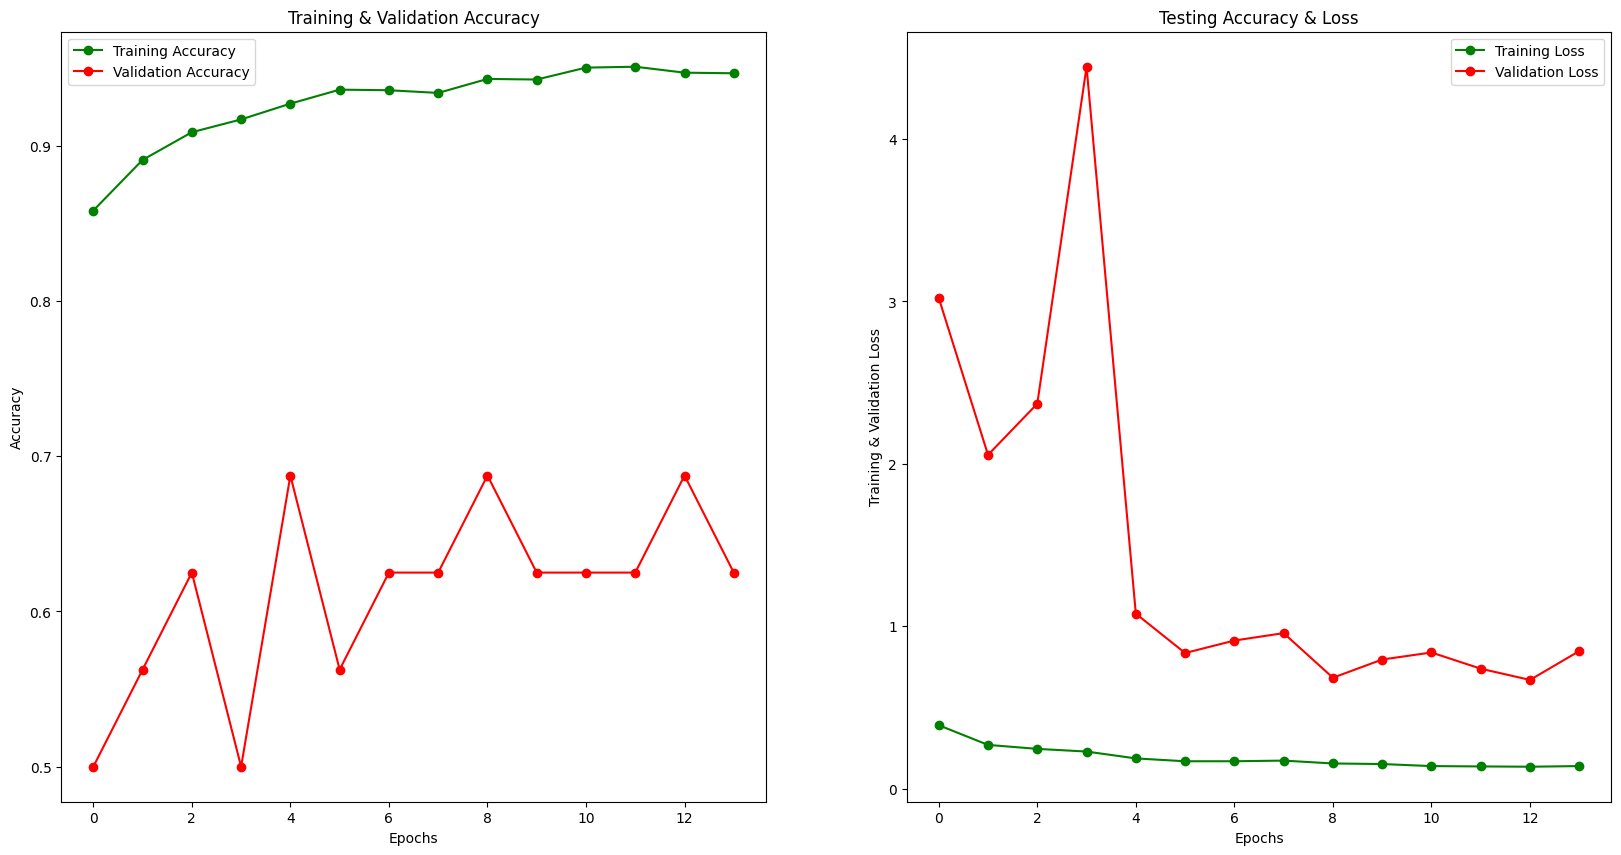

In [ ]:
epochs = [i for i in range(14)]

# Crear una figura y dos subplots
fig , ax = plt.subplots(1,2)

# Obtener los datos de precisión y pérdida de entrenamiento y validación
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Establecer el tamaño de la figura
fig.set_size_inches(20,10)

# Graficar precisión de entrenamiento y validación en el primer subplot
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Graficar pérdida de entrenamiento y validación en el segundo subplot
ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

# Mostrar el gráfico
plt.show()


Image 1 - True label: NORMAL
1/1 [==============================] - 0s 188ms/step
NORMAL: 98.57%
PNEUMONIA: 1.43%


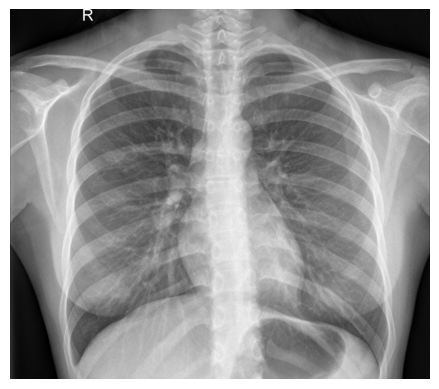


Image 2 - True label: NORMAL
1/1 [==============================] - 0s 88ms/step
NORMAL: 97.57%
PNEUMONIA: 2.43%


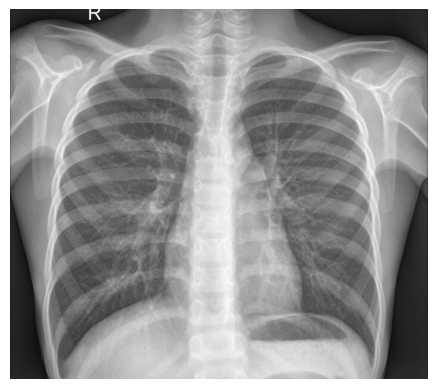


Image 3 - True label: NORMAL
1/1 [==============================] - 0s 116ms/step
NORMAL: 97.73%
PNEUMONIA: 2.27%


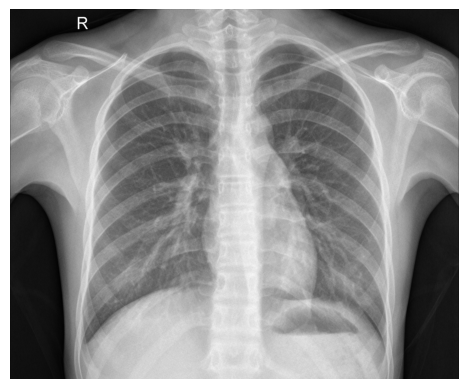


Image 4 - True label: NORMAL
1/1 [==============================] - 0s 39ms/step
NORMAL: 92.98%
PNEUMONIA: 7.02%


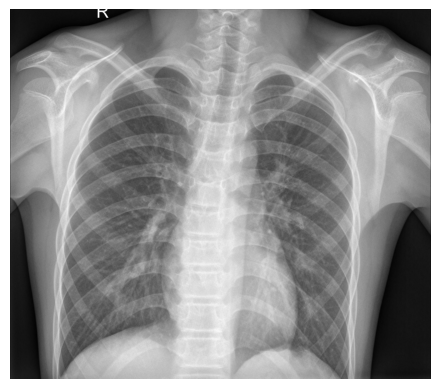


Image 5 - True label: NORMAL
1/1 [==============================] - 0s 72ms/step
NORMAL: 95.83%
PNEUMONIA: 4.17%


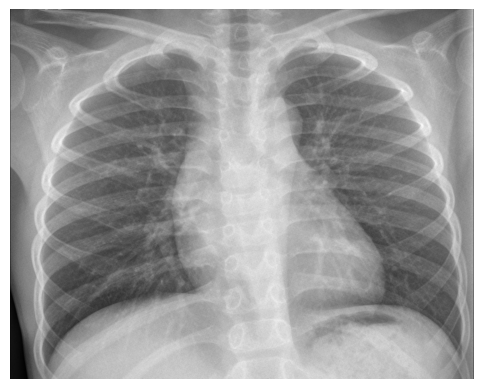


Image 6 - True label: PNEUMONIA
1/1 [==============================] - 0s 32ms/step
PNEUMONIA: 89.75%
NORMAL: 10.25%


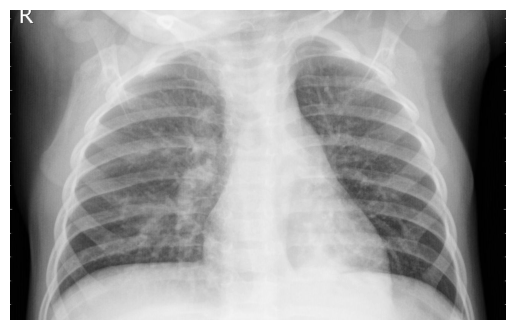


Image 7 - True label: PNEUMONIA
1/1 [==============================] - 0s 126ms/step
PNEUMONIA: 99.88%
NORMAL: 0.12%


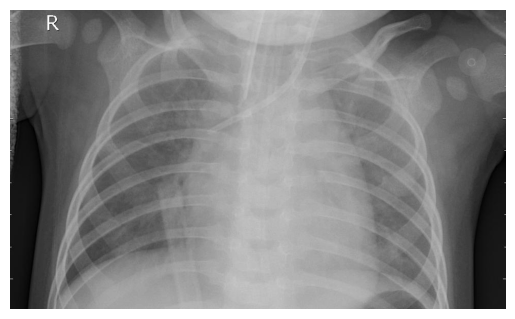


Image 8 - True label: PNEUMONIA
1/1 [==============================] - 0s 75ms/step
PNEUMONIA: 99.85%
NORMAL: 0.15%


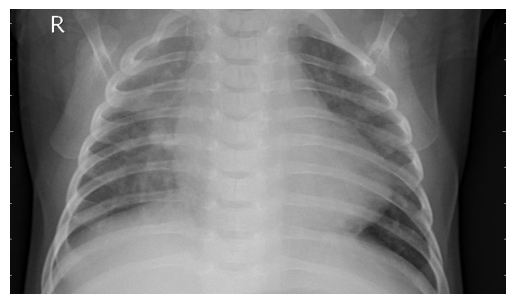


Image 9 - True label: PNEUMONIA
1/1 [==============================] - 0s 24ms/step
PNEUMONIA: 99.72%
NORMAL: 0.28%


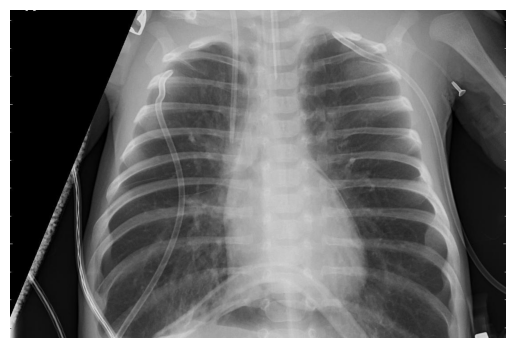


Image 10 - True label: PNEUMONIA
1/1 [==============================] - 0s 24ms/step
PNEUMONIA: 99.98%
NORMAL: 0.02%


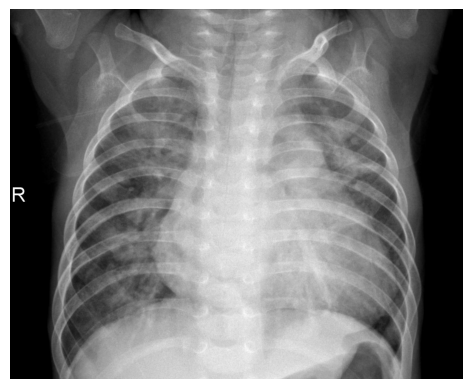

In [ ]:
dic = train_generator.class_indices
icd = {k:v for v,k in dic.items()}

def output(location):
    img = load_img(location, target_size=(150, 150, 3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict_x = model.predict(img)[0]
    sorted_indexes = np.argsort(predict_x)[::-1]
    for index in sorted_indexes:
        print(f"{icd[index]}: {predict_x[index]*100:.2f}%")
    image = plt.imread(location)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.show()

# Obtener la lista de etiquetas
labels = list(train_generator.class_indices.keys())

# Obtener algunas imágenes de prueba y sus etiquetas verdaderas
image_list = []
true_labels = []
for label in labels:
    path = os.path.join(test_dir, label)
    images = os.listdir(path)[:5] # tomar solo las primeras 5 imágenes
    for img in images:
        image_list.append(os.path.join(path, img))
        true_labels.append(label)
true_labels = np.array(true_labels)

# Mostrar algunas imágenes de prueba con etiquetas predichas
for i in range(10):
    image_path = image_list[i]
    label = true_labels[i]
    print(f"\nImage {i+1} - True label: {label}")
    output(image_path)



In [ ]:
#Evaluar el modelo con el set de test
test_loss, test_accuracy = model.evaluate(test_generator)

# Print el loss y accuaraccy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

52/52 [==============================] - 7s 141ms/step - loss: 0.3307 - accuracy: 0.8926
Test Loss: 0.33072492480278015
Test Accuracy: 0.8926281929016113
